In [38]:
from spaces import *
from mark_constants import *

def to_video(imgs, path, res=(70*4,30*4), fps=30.0):
    import cv2
    fourcc = cv2.VideoWriter_fourcc(*'MPEG')
    writer = cv2.VideoWriter(path, fourcc, fps, res)
    for img in imgs:
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        writer.write(img)
    writer.release()
    
def draw(particles, start, goal, robot, sensors, counter=None):
    space = GridSpace([70*4,30*4])
    normalizer = np.array([7.,3.])
    space.draw_line(start/normalizer, goal/normalizer, LIGHT_RED)
    for p in particles:
        space.draw_point(p/normalizer, LIGHT_GREEN)
    for sensor in sensors:
        space.draw_point(sensor/normalizer, LIGHT_BLUE)
    space.draw_point(start/normalizer, GREEN)
    space.draw_point(goal/normalizer, RED)
    space.draw_point(robot/normalizer, BLUE)
        
    if counter is None: return space.display()
    else: return space.display(path='particle_filter/%s.png' % str(counter).zfill(2))

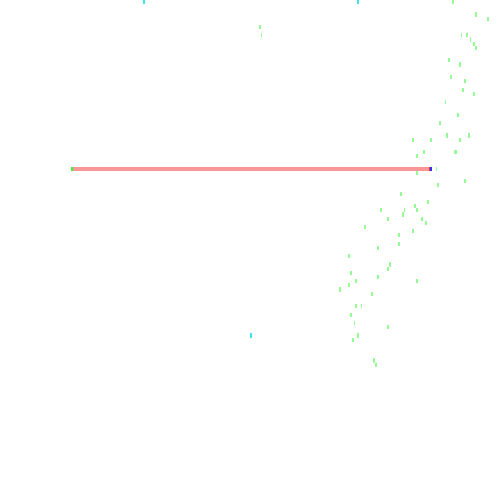

In [42]:
import numpy as np
from scipy.stats import norm
import time

animate = True
fps = 10.0
M = 200
process_noise_sd = 0.2
sensor_noise_sd = 0.25
start = np.array((1., 1.))
goal = np.array((6., 1.))
sensors = np.array([(2., 0.), (5., 0.), (3.5, 2.)])


particles = []
for i in range(M):
    p = np.random.rand(2) * np.array([7,3])
    particles.append(p)
particles = np.array(particles)

#true state
state = np.copy(start) #np.random.rand(2) * np.array([7,3])
belief = particles

def get_distance(p):
    S = sensors.shape[0]
    distances = np.zeros(S)
    for i in range(S):
        distances[i] = np.linalg.norm(p-sensors[i])
    return np.min(distances)

imgs = []
counter = 0#if at goal for X frames, stop
while True:
    diff = goal - state #follow predefined path
    
    if np.linalg.norm(diff) < 0.05:
        mov = [0,0]
        counter += 1
        if counter > 15: break
    elif abs(diff[0]) > abs(diff[1]):
        mov = [1,0] if diff[0] > 0 else [-1,0]
    else:
        mov = [0,1] if diff[1] > 0 else [0,-1]
    mov = np.array(mov)
    noise = np.random.normal(0, process_noise_sd) * mov
    mov = mov*0.2
    
    state += mov + noise
    distance = get_distance(state)
    distance += np.random.normal(0, sensor_noise_sd)
    
    #generate particles using model probability p(x_t|x_t-1, u_t) = N(predicted position, process noise)
    for i in range(M):
        particles[i] = np.random.normal(particles[i]+mov, process_noise_sd, 2)
        
    #redraw from generated particles with weights proportional to sensor model p(z_t|x_t)
    weights = np.zeros(M)
    for i in range(M):
        distance_particle = get_distance(particles[i])
        #p(distance) where p(x)~N(distance_particle, sensor_noise_sd)
        weights[i] = norm.pdf(distance, distance_particle, sensor_noise_sd)
    weights /= np.sum(weights)
    choices = np.random.choice(M, size=M, replace=True, p=weights)
    particles = particles[choices]
    
    imgs.append(draw(particles, start, goal, state, sensors))
    if animate:
        time.sleep(1/fps)
    
to_video(imgs, 'pfilter.avi', res=(70*4,30*4), fps=fps)
        

